In [1]:
%matplotlib inline

### SARSA todo

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import collections
import matplotlib

figsize=(15, 9)
matplotlib.rcParams.update({'font.size': 22})

In [3]:
# Class Bandit
class Bandit():
    def __init__(self, k_arms=10, gibbs=False, initial=0., epsilon=0., true_reward = 0., temp=1., 
                step_size=.1, gradient=False, sample_average=False, reinforcement=False, beta=1.,
                pursuit = False, constant=False, adaptive=False, UCB=False, UCB_parameter = 1.,
                reducer=None):
        self.k = k_arms
        self.initial = initial
        self.eps = epsilon
        self.average_reward = 0.
        self.indices = np.arange(k_arms)
        self.true_reward = true_reward
        self.gibbs = gibbs
        self.time = 0
        self.temp = temp
        self.step_size = step_size
        self.gradient = gradient
        self.sample_average = sample_average
        self.reinforcement = reinforcement
        self.beta = beta
        self.constant = constant
        self.adaptive = adaptive
        self.pursuit = pursuit
        self.UCB = UCB
        self.UCB_parameter = UCB_parameter
        self.reducer = reducer
        
    def reset(self):
        """
            Get the true and estimated values of the actions 
        """
        self.q_true = np.random.randn(self.k) + self.true_reward
        
        self.q_estimation = np.zeros(self.k) + self.initial
        
        self.action_count = np.zeros(self.k)  # how many times each arm was selected
        
        self.best_action = np.argmax(self.q_true)
        
    def act(self):
        """
            Get an action for the bandit
        """
        # esp-greedy
        if np.random.rand(1) < self.eps:
            return np.random.choice(self.indices)
        # softmax
        if self.gibbs:
            self.action_probs = np.exp(self.q_estimation / self.temp) / np.sum(np.exp(self.q_estimation / self.temp))
            return np.random.choice(self.indices, p=self.action_probs)            
        # reinforcement
        if self.reinforcement:
            self.action_probs = np.exp(self.q_estimation) / np.sum(np.exp(self.q_estimation))
            return np.random.choice(self.indices, p=self.action_probs) 
        # pursuit strategy
        if self.pursuit:
            q_best = np.argmax(self.q_estimation)
            self.action_probs = np.exp(self.q_estimation) / np.sum(np.exp(self.q_estimation))
            self.action_probs[q_best] += self.beta * (1 - self.action_probs[q_best])
            
#             art = [self.action_probs[q] for q, v in enumerate(self.q_estimation) if q != np.argmax(self.q_estimation)]

            temporary = self.action_probs - self.beta * self.action_probs
            temporary[q_best] = 0
            self.action_probs += temporary
            self.action_probs = np.exp(self.action_probs) / np.sum(np.exp(self.action_probs))
            return np.random.choice(self.indices, p=self.action_probs) 
        if self.UCB:
#             if self.time % self.reducer == 0 and self.reducer is not None:
#                 self.UCB_parameter /= 1.3
            ucb = self.q_estimation + self.UCB_parameter * np.sqrt(2 * np.log(self.time + 1)) / \
                                                                (self.action_count + 1e-4)
            return np.argmax(ucb)
            
        return np.argmax(self.q_estimation)  # greedy
    
    def step(self, action):
        """
            Get the reward and update the estimation
        """
        reward = np.random.rand() + self.q_true[action]
        self.time += 1
        self.average_reward = (self.time-1.) * (self.average_reward) / self.time + reward / self.time
        self.action_count[action] += 1
        if self.sample_average:
            self.q_estimation[action] += 1. / self.action_count[action] * (reward - self.q_estimation[action])
#         elif self.gradient:
#             self.q_estimation[action] = self.q_estimation[action] + self.step_size * \
#                                                             (reward - self.q_estimation[action])
        elif self.reinforcement:
            ethalone = self.average_reward
            self.q_estimation[action] += self.beta * (reward - ethalone) * (1 - self.action_probs[action])
            self.average_reward += self.step_size * (reward - ethalone)
        
        elif self.constant:  # constant step size
            self.q_estimation[action] = self.q_estimation[action] + self.step_size * \
                                                            (reward - self.q_estimation[action])
        elif self.adaptive:
            self.q_estimation[action] = self.q_estimation[action] + 1/self.action_count[action] * \
                                                            (reward - self.q_estimation[action])
        elif self.pursuit:
            self.q_estimation[action] += 1. / self.action_count[action] * (reward - self.q_estimation[action])
        elif self.UCB:
            self.q_estimation[action] += 1. / self.action_count[action] * (reward - self.q_estimation[action])
        return reward

### Graphics illustrating the work of different approaches

In [4]:
def simulate(runs, time, bandits, k_arms=10):
    best_actions = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_actions.shape)
    
    for i, b in enumerate(bandits):
        for r in tqdm_notebook(range(runs), total = runs):
            b.reset()
            for t in range(time):
                action = b.act()
                reward = b.step(action)
                rewards[i, r, t] = reward
                if action == b.best_action:
                    best_actions[i, r, t] = 1
    best_actions = best_actions.mean(axis=1)
    mean_reward = rewards.mean(axis=1)
    return best_actions, mean_reward

In [64]:
def esp_greedy_softmax_plot(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps) for eps in epsilons]
    bandits.append(Bandit(gibbs=True, epsilon=0., temp=.5))
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards[:-1]):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.plot(rewards[-1], label='softmax')
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts[:-1]):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.plot(best_action_counts[-1], label='softmax')
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

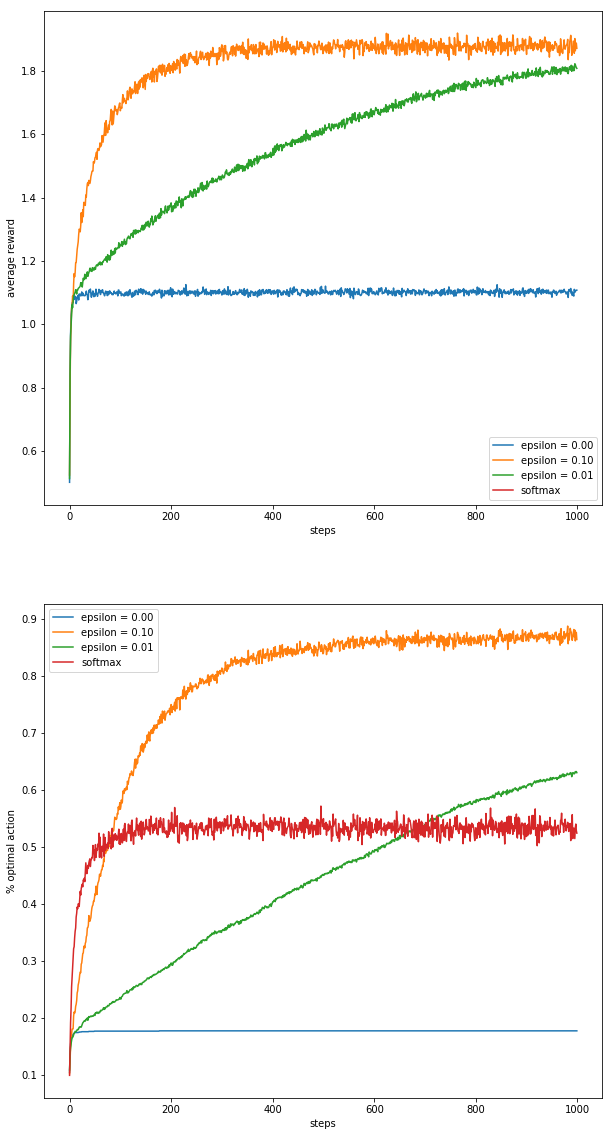

In [65]:
esp_greedy_softmax_plot()

In [81]:
def optimistic_eps(runs=2000, time=2000):
    bandits = [Bandit(epsilon=.1)]
    bandits.append(Bandit(epsilon=0., initial=5))
    best_actions, rewards = simulate(runs, time, bandits)
    labels = ['eps = 0.1',
            'initial=5']
    
    
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.ylabel('average reward')
    plt.legend()

A Jupyter Widget

A Jupyter Widget

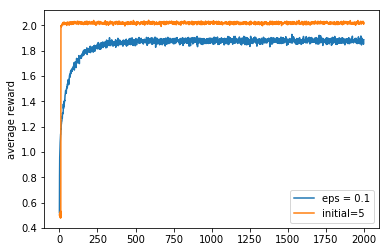

In [82]:
optimistic_eps()

In [107]:
def constant_eps_optimistic(runs=2000, time=2000):
    bandits = [Bandit(epsilon=.1, sample_average=True),
              Bandit(epsilon=0., sample_average=False),
              Bandit(epsilon=.1, sample_average=True, initial=5),
              Bandit(reinforcement=False, epsilon=0., beta=.2, initial=5.)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['eps=0.1',
             'alpha=0.1, eps=0.1',
             'initial=5, eps=0.1',
             'reinforcement']
    plt.subplots(figsize=figsize)
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.legend()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

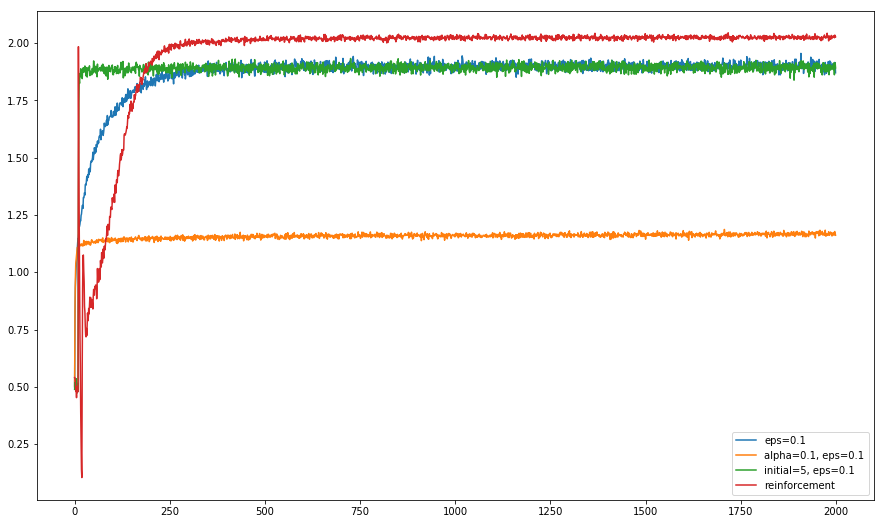

In [108]:
constant_eps_optimistic()

In [114]:
def adaptive(runs=2000, time=2000):
    bandits = [Bandit(epsilon=.1, sample_average=True),
              Bandit(epsilon=.1, adaptive=True),
              Bandit(reinforcement=True, epsilon=0., beta=.2, initial=5.)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['eps=0.1',
             'alpha=1/k, eps=0.1',
             'reinforcement']
    plt.subplots(figsize=figsize)
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.legend()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

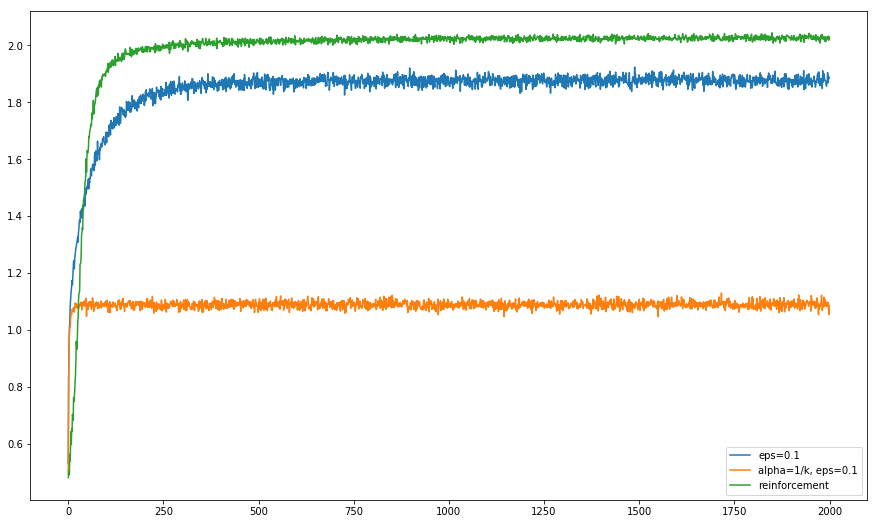

In [115]:
adaptive()

In [118]:
def reinforcement_euristic(runs=2000, time=2000):
    bandits = [Bandit(epsilon=.1, sample_average=True),
              Bandit(reinforcement=True, epsilon=0., beta=.2, initial=5.)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['eps=0.1',
             'reinforcement']
    plt.subplots(figsize=figsize)
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.legend()

A Jupyter Widget

A Jupyter Widget

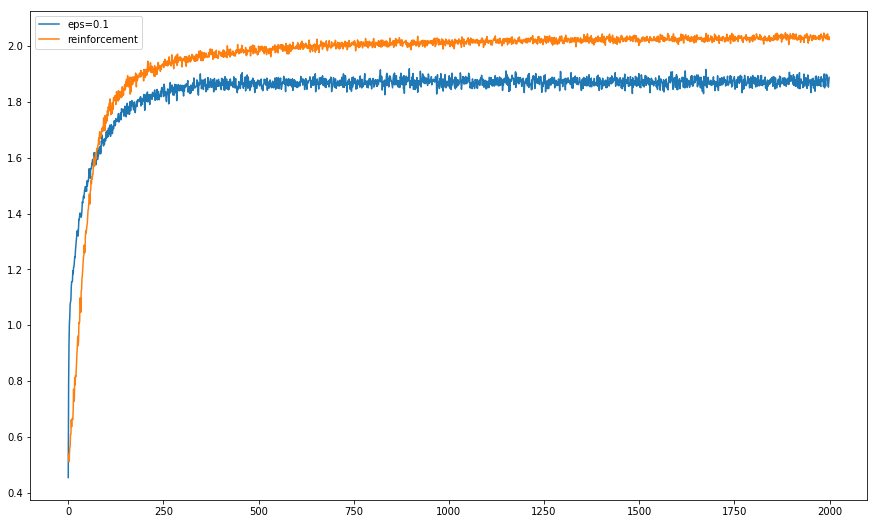

In [119]:
reinforcement_euristic()

In [4]:
def pursuit(runs=2000, time=2000):
    bandits = [Bandit(pursuit=True, beta=0.05),
               Bandit(epsilon=.1, sample_average=True)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['eps=0.1',
             'reinforcement',
             'pursuit']
    plt.subplots(figsize=figsize)
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.legend()

A Jupyter Widget

A Jupyter Widget

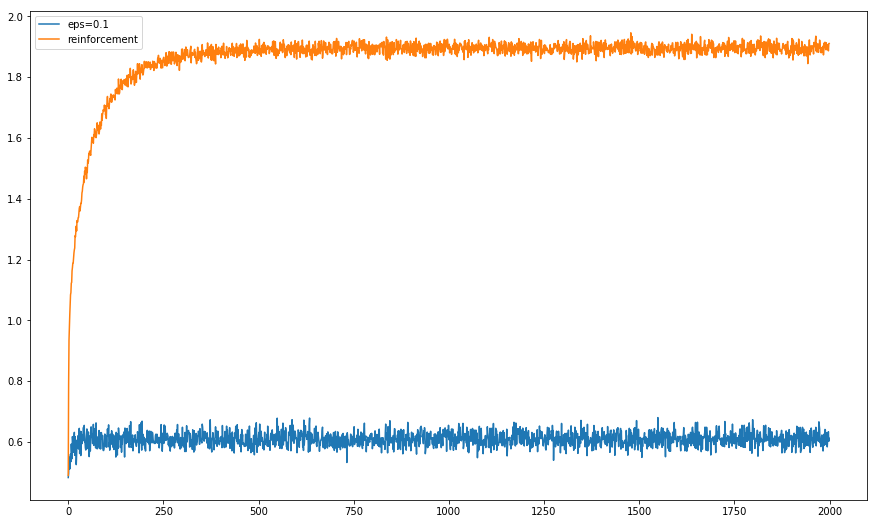

In [7]:
pursuit()

In [17]:
def UCB(runs=2000, time=2000):
    bandits = [Bandit(UCB=True, UCB_parameter=1.5, reducer=None),
               Bandit(epsilon=.1, sample_average=True),
              Bandit(reinforcement=True, beta=.2)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['UCB',
             'eps=0.1',
             'reinforcement']
    plt.subplots(figsize=figsize)
    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.legend()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

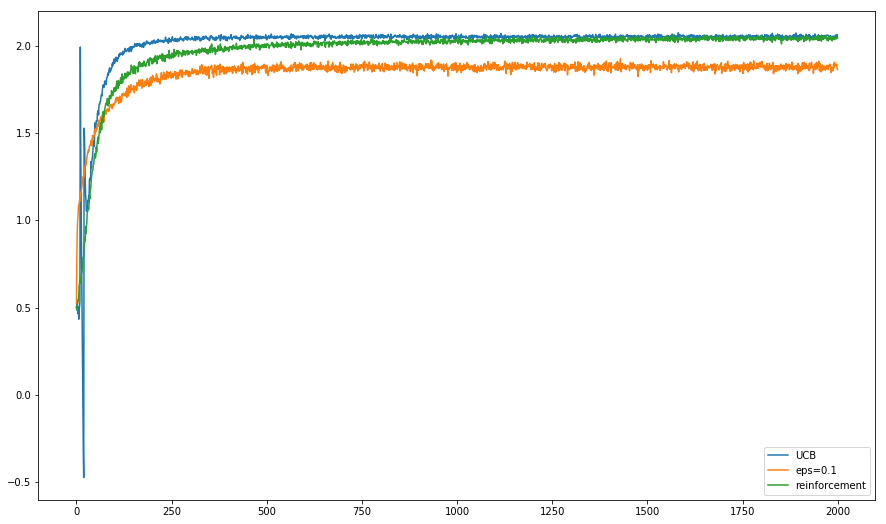

In [18]:
UCB()

### UCB и reinforcement показывают себя лучше, хотя сравнение-подкрепление сходится быстрее

In [17]:
def UCB_100(runs=2000, time=1000):
    bandits = [Bandit(k_arms=10, UCB=True, UCB_parameter=1, reducer=None),
               Bandit(k_arms=10, reinforcement=True, beta=0.2),
               Bandit(k_arms=10, epsilon=.1, sample_average=True),
               Bandit(k_arms=10, epsilon=0., sample_average=True)]
    best_action, rewards = simulate(runs, time, bandits)
    labels = ['UCB',
             'reinforcement',
             'greedy e=0.1',
             'greedy e=0']
    plt.subplots(figsize=figsize)

    for i, reward in enumerate(rewards):
        plt.plot(reward, label=labels[i])
    plt.xlabel('Step')
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig('ucb_reinforcement_greedy_e.png')
    return best_action, rewards

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

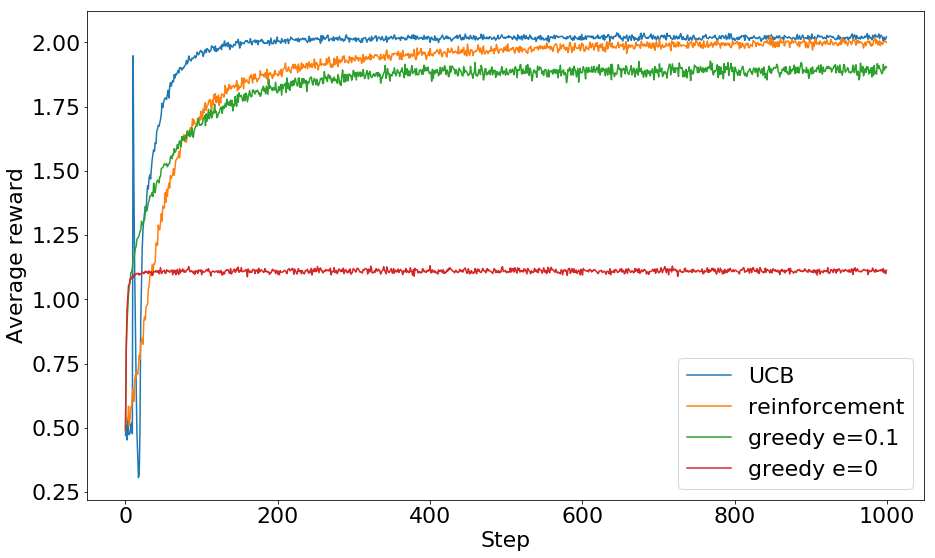

In [18]:
best, rew = UCB_100()

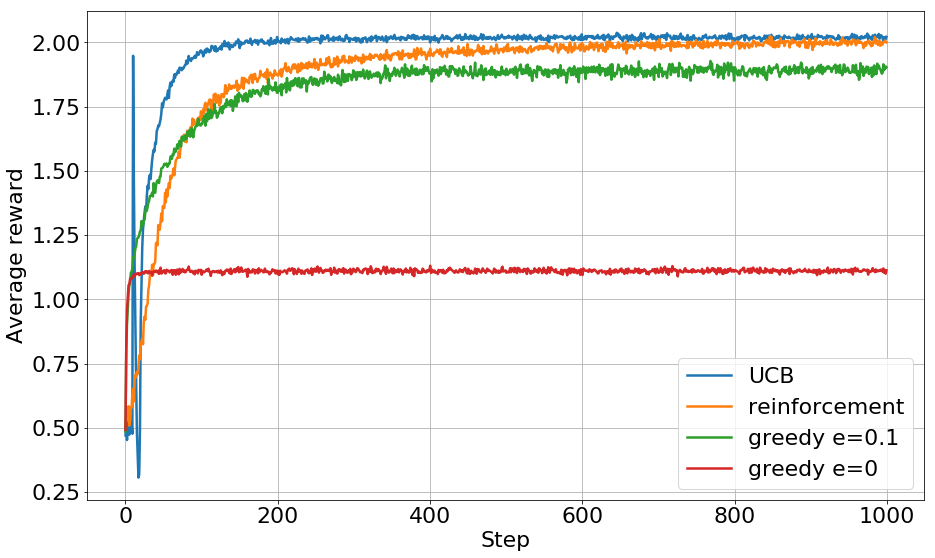

In [23]:
labels = ['UCB',
         'reinforcement',
         'greedy e=0.1',
         'greedy e=0']
plt.subplots(figsize=figsize)

for i, reward in enumerate(rew):
    plt.plot(reward, label=labels[i], lw=2.5)

plt.xlabel('Step')
plt.ylabel('Average reward')
plt.legend()
plt.grid()
plt.savefig('ucb_reinforcement_greedy_e_reward_2.png')